# Rummikub

In [1]:
import numpy as np
import random
from numpy import random as rm
from scipy import linalg
from matplotlib import pyplot as plt
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher as GM
import itertools as it
import functools as ft
import operator as op

In [2]:
def powerassociate(op):
    def f(xs):
        l = len(xs)
        if l > 2:
            return op(f(xs[::2]), f(xs[1::2]))
        elif l == 2:
            return op(*xs)
        else:
            return xs[0]
    return f

## Tile setup

All tiles.

In [3]:
tilenumbers = range(13)
tilecolors  = ['#ff0000', '#00ff00', '#0000ff', '#ff00ff']
edgecolors  = ['#00000088', '#00000088']

Rules for different kinds of runs.

In [4]:
edgetypes = range(2)
def tilegraph(tiles):
    G = nx.MultiGraph()
    for a, b in it.combinations(tiles, 2):
        dn, dc = np.subtract(a, b)
        if abs(dn) == 1 and dc == 0:
            G.add_edge(*((a,b) if dn < 0 else (b,a)), type=0)
        if dn == 0:
            G.add_edge(*((a,b) if dc < 0 else (b,a)), type=1)
    return G

def edgetype(t, edges, same=True):
    return [(a, b, k) for a, b, k, et in edges if same ^ et != t]
def graphedgetype(t, G, same=True):
    return edgetype(t, G.edges(data='type', keys=True), same)
def graphtypes(G, edgetypes):
    return [G.edge_subgraph(graphedgetype(t, G)) for t in edgetypes]

def validrun(G, t):
    if t == 0: # A path of at least three numbers (same color)
        return GM(G, nx.path_graph(3)).subgraph_is_isomorphic()
    elif t == 1: # A collection of at least three colors (same number)
        return GM(G, nx.complete_graph(3)).subgraph_is_isomorphic()
    else: # TODO: Jokers
        return False

A graph is valid if all its components for each edge type are valid, and if the edge types form a partition of the whole graph.

If the symmetric difference $\ominus_n S_n = \cup_n S_n$, then the $S_n$ form a partition.

In [5]:
def validtiles(G):
    Gtypes = graphtypes(G, edgetypes)
    okruns = all(validrun(Gtype.subgraph(c), t)
                 for t, Gtype in enumerate(Gtypes)
                 for c in nx.connected_components(Gtype))
    ispartition = set(G) == powerassociate(lambda x, y: x ^ y)([set(Gtype) for Gtype in Gtypes])
    return okruns and ispartition

Drawing tiles.

In [6]:
def tilelayout(G):
    return {(n, c): np.array([-1 + 2*(n+1) / (len(tilenumbers)+1), -1 + 2*(c+1) / (len(tilecolors)+1)]) for n, c in G}

def drawtiles(G):
    return nx.draw(G, pos=tilelayout(G),
                   labels={x: x[0] for x in G},
                   node_color=[tilecolors[x[1]] for x in G],
                   node_shape='s', # so^>v<dph8
                   edge_color=[edgecolors[t] for _, _, t in G.edges(data='type')],
                   font_family='serif', font_color='#ffffff')

## A testing set of tiles

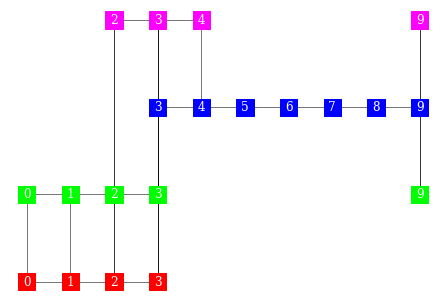

In [7]:
# tiles = random.sample([e for e in it.product(range(len(tilenumbers)), range(len(tilecolors)))] * 2, 35)
# tiles = [(n, 2) for n in range(4)]
tiles = [(0, 0), (1, 0), (2, 0), (3, 0),
         (0, 1), (1, 1), (2, 1), (3, 1),
         (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2),
         (9, 1), (9, 2), (9, 3),
         (2, 3), (3, 3), (4, 3)
        ]
G = tilegraph(tiles)
drawtiles(G)

## Finding all configurations of a partable graph
A *partable* graph is a graph where all nodes can mutually parts of valid runs.

Remove edges that cannot be used in runs.

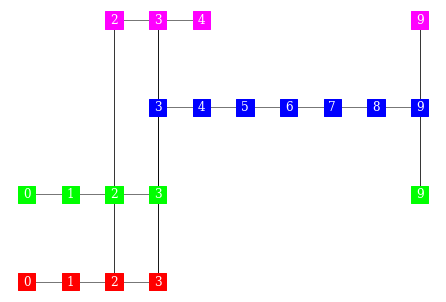

In [8]:
def pruneedges(G):
    for t, Gtype in enumerate(graphtypes(G, edgetypes)):
        for c in nx.connected_components(Gtype.to_undirected()):
            s = Gtype.subgraph(c).copy()
            if not validrun(s, t):
                G.remove_edges_from(s.edges)
pruneedges(G)
drawtiles(G)

Find edges connected to nodes of multiple edge types (nodes that are not yet partitioned).

In [9]:
mixed = set.intersection(*map(set, graphtypes(G, edgetypes)))
medgesels = []
for m in mixed:
    medges = G.edges(m, keys=True, data='type')
    medgesels.append([edgetype(t, medges, same=False) for t in set(map(lambda e: e[3], medges))])

Try all partitionings by selecting an edge type and removing the rest for each mixed node.

Removal order matters! Consider a node $J$ of degree $d_J$ connected like a star to other star-like nodes of degree $d_S$. Choosing $J$ first then the others gives
$$
G_J(d_J) = d_J + (d_J - 1)(d_S - 1)
$$
graphs, while choosing each of the spokes first and then $J$ last gives
$$
G_S(d_J)
= (d_S - 1)G_S(d_J - 1) + (d_J - 1)(d_S - 1)
= (d_S - 1)(G_S(d_J - 1) + d_J - 1)
$$
graphs, which is *many* more.

In [10]:
newGs = []
for p in it.product(*medgesels):
    newG = G.copy()
    newG.remove_edges_from(it.chain(*p))
    newGs.append(newG)

In [11]:
validGs = list(filter(validtiles, newGs))

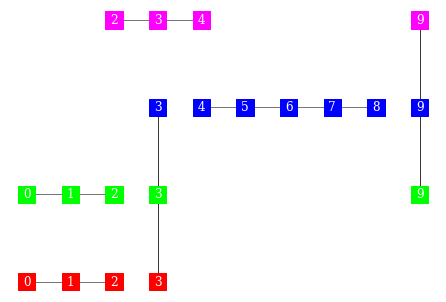

In [12]:
drawtiles(validGs[1])

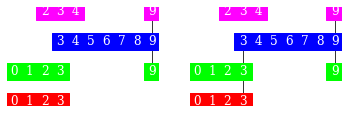

In [13]:
gridsize = np.ceil(np.sqrt(len(validGs)))
for i, g in enumerate(validGs):
    plt.subplot(gridsize, gridsize, i+1)
    drawtiles(g)

## Maximal runable subgraph
TODO: Recursive algorithm on connected components?